In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler                   
from tensorflow.keras import Sequential                             
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation
import plotly.graph_objects as go

In [27]:
SBIN = pd.read_csv('SBIN_EQN_data.csv', index_col=None, header=0)

In [28]:
SBIN.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,SBIN,EQ,01-Jan-18,309.90,310.6,312.75,306.30,306.75,307.10,309.08,12182400,3.765315e+09,75769,5697288,46.77
1,SBIN,EQ,02-Jan-18,307.10,309.0,309.00,301.35,303.00,303.25,304.00,14797364,4.498328e+09,100195,5698196,38.51
2,SBIN,EQ,03-Jan-18,303.25,305.3,306.45,302.15,302.80,302.85,304.32,13857373,4.217070e+09,117207,6941140,50.09
3,SBIN,EQ,04-Jan-18,302.85,304.5,310.20,303.15,309.25,308.50,307.63,24517099,7.542211e+09,140513,10508054,42.86
4,SBIN,EQ,05-Jan-18,308.50,311.4,311.40,305.60,307.25,306.35,308.05,14580575,4.491544e+09,91829,4896408,33.58


In [29]:
SBIN_Req = SBIN[['Date','Open Price','High Price','Low Price','Close Price','Average Price']]

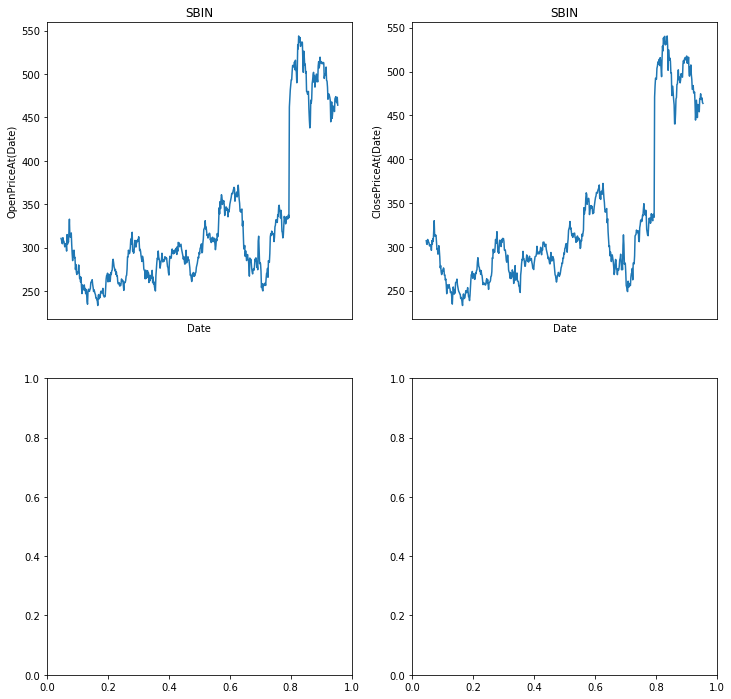

In [30]:
#Single plot
figure, axis = plt.subplots(2,2,figsize=(12,12))
axis[0][0].plot(SBIN_Req['Date'],SBIN_Req['Open Price'])
axis[0][0].set_title('SBIN')
axis[0][0].set_xlabel('Date')
axis[0][0].set_ylabel('OpenPriceAt(Date)')
axis[0][0].xaxis.set_major_locator(mdates.DayLocator((1,15)))
axis[0][0].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

axis[0][1].plot(SBIN_Req['Date'],SBIN_Req['Close Price'])
axis[0][1].set_title('SBIN')
axis[0][1].set_xlabel('Date')
axis[0][1].set_ylabel('ClosePriceAt(Date)')
axis[0][1].xaxis.set_major_locator(mdates.DayLocator((1,15)))
axis[0][1].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

##Parameters of the model

In [32]:
past_days = 100
train_test = 0.8
predict_next_days = 7
no_of_epochs = 50
batch_size = 8

##Model building

In [34]:
SBIN_Req.columns

Index(['Date', 'Open Price', 'High Price', 'Low Price', 'Close Price',
       'Average Price'],
      dtype='object')

In [35]:
#Initalising empty list for testing and training data
x_train = []
y_train = []
x_test = []
y_test = []

In [37]:
#We are going to predict the Open price of the stock
Open_data = np.asarray(SBIN_Req['Open Price'])
Open_data[:10]

array([310.6 , 309.  , 305.3 , 304.5 , 311.4 , 307.2 , 307.5 , 304.65,
       300.9 , 304.65])

In [38]:
#Reshaping to automatically make it a 2d-array which is the input for sequential model
Open_data = Open_data.reshape(-1,1)
Open_data[:10]

array([[310.6 ],
       [309.  ],
       [305.3 ],
       [304.5 ],
       [311.4 ],
       [307.2 ],
       [307.5 ],
       [304.65],
       [300.9 ],
       [304.65]])

In [39]:
#We scale the data to make the data modelling easier
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(Open_data)

In [40]:
train_test

0.8

In [42]:
#We find the index for train_test_split as spefied ratio by the user above in the parameters
training_data_len = int(len(SBIN_Req)*train_test)
training_data_len

476

In [43]:
#Here we split the training data
train_data = scaled_data[0:training_data_len,:]
for i in range(past_days,len(train_data)):
    x_train.append(train_data[i-past_days:i,0])
    y_train.append(train_data[i, 0])

x_train= np.array(x_train)
y_train= np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))

In [45]:
#Here we split the testing data
test_data = scaled_data[training_data_len-past_days:]
x_test = []
actual_data = Open_data[training_data_len:, :]
y_test = scaled_data[training_data_len:, :]
for i in range(past_days, len(test_data)):
    x_test.append(test_data[i-past_days:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1))

In [46]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=32, return_sequences=False))
# model.add(Dense(64))
model.add(Dense(32))
# model.add(Dense(16))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

In [47]:
# Fitting the training data and fitting the data to LSTM.
# It uses a mse loss, we usually use MSE for regression. We can use Adam or Rmsprop optimizer
model.fit(x_train, y_train, batch_size=batch_size, epochs=no_of_epochs)

Epoch 1/50
47/47 [==============================] - 6s 44ms/step - loss: 0.0055
Epoch 2/50
47/47 [==============================] - 2s 44ms/step - loss: 0.0028
Epoch 3/50
47/47 [==============================] - 2s 42ms/step - loss: 0.0019
Epoch 4/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0016
Epoch 5/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0016
Epoch 6/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 7/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 8/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 9/50
47/47 [==============================] - 2s 43ms/step - loss: 9.6199e-04
Epoch 10/50
47/47 [==============================] - 2s 43ms/step - loss: 9.8491e-04
Epoch 11/50
47/47 [==============================] - 2s 43ms/step - loss: 0.0010
Epoch 12/50
47/47 [==============================] - 2s 44ms/step - loss: 8.6561e-04
Epoch 13/50
47/47 [======

## Loss values

In [48]:
#Predict the data for test data and checked the mse for scalled data
predictions = model.predict(x_test)
mse = np.mean(predictions-y_test)**2
predictions = scaler.inverse_transform(predictions)
mse

2.1893518418788985e-05

In [49]:
#MSE for actual data
np.mean(actual_data-predictions)**2

2.113467441268281

In [50]:
#Just printing and showing the predicted and actual data - this is a size of past_days
for i in range(len(predictions)):
  print(predictions[i],actual_data[i])

[320.70255] [317.2]
[317.4977] [311.2]
[311.86066] [314.]
[313.95636] [325.2]
[324.60104] [335.95]
[335.6399] [333.25]
[333.81137] [335.]
[335.14334] [327.35]
[328.13217] [330.35]
[330.52124] [335.7]
[336.03378] [333.2]
[334.23633] [333.]
[333.8789] [333.4]
[334.22156] [337.75]
[338.37308] [334.4]
[335.4849] [462.]
[466.2689] [472.5]
[477.6799] [481.9]
[487.6714] [487.7]
[494.33203] [493.45]
[501.64493] [493.35]
[501.94156] [503.]
[513.4272] [509.9]
[520.0121] [510.]
[518.9245] [509.]
[517.25305] [508.]
[515.54663] [514.]
[521.8283] [505.]
[510.0669] [516.]
[523.23456] [505.3]
[508.9295] [502.4]
[506.67426] [490.]
[492.3659] [503.55]
[508.4957] [534.]
[541.3748] [529.]
[531.6432] [543.95]
[550.4434] [536.65]
[540.12286] [537.15]
[542.76953] [542.15]
[548.65924] [531.9]
[536.29443] [535.5]
[542.1198] [534.95]
[540.55457] [537.1]
[543.0359] [536.25]
[541.498] [515.]
[517.1512] [502.]
[504.89053] [526.5]
[533.63434] [520.]
[522.43097] [510.1]
[512.15466] [511.55]
[514.65] [500.9]
[502.196

##Predict next 7 days

In [52]:
#Predict for the next x days gice. Here x is the predict_next_days. Input the parameter in parameters section
count = predict_next_days
next_days = []
Open_data_list = list(Open_data)
while(count!=0):
  last = Open_data_list[-past_days:]
  last_data = np.asarray(last, dtype=object)
  last_data = last_data.reshape(-1,1)
  last_scalled = scaler.transform(last_data)
  x_test = []
  x_test.append(last_scalled)
  x_test = np.array(x_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1))
  prediction = model.predict(x_test)
  prediction = scaler.inverse_transform(prediction)
  next_days.append(prediction[0][0])
  Open_data_list.append(prediction[0][0])
  count-=1

print(next_days)

[465.0056, 466.50162, 467.93585, 469.32608, 470.6669, 472.0002, 473.38007]


In [53]:
train = list(SBIN_Req['Open Price'])[:training_data_len]
print(train)
test = list(SBIN_Req['Open Price'])[training_data_len:]
print(test)

date_train = list(SBIN_Req['Date'])[:training_data_len]
date_test = list(SBIN_Req['Date'])[training_data_len:]
date_next = ['1st Day','2nd Day','3rd Day','4th Day','5th Day','6th Day','7th Day']

[310.6, 309.0, 305.3, 304.5, 311.4, 307.2, 307.5, 304.65, 300.9, 304.65, 303.95, 302.4, 296.0, 315.0, 303.95, 308.35, 306.4, 317.7, 332.75, 313.15, 312.05, 313.0, 316.9, 302.9, 292.65, 285.0, 296.6, 292.9, 297.0, 288.25, 288.7, 274.8, 280.5, 271.5, 269.0, 272.2, 270.4, 273.45, 280.0, 273.0, 264.25, 266.3, 260.45, 265.85, 255.05, 247.0, 257.0, 254.1, 251.3, 252.5, 257.0, 250.65, 252.9, 246.85, 251.75, 247.0, 237.8, 234.75, 250.0, 252.0, 251.8, 249.55, 251.7, 252.6, 259.65, 260.65, 261.1, 263.0, 257.5, 254.0, 249.35, 251.4, 249.5, 247.1, 245.85, 241.9, 242.0, 239.7, 238.4, 233.25, 244.8, 245.9, 240.95, 243.5, 242.45, 248.0, 249.8, 248.25, 247.6, 249.95, 253.0, 245.5, 244.2, 243.0, 243.55, 243.65, 254.65, 263.85, 267.8, 267.4, 270.5, 260.5, 266.85, 269.25, 268.0, 260.9, 263.0, 271.05, 268.95, 273.3, 274.0, 284.0, 286.55, 282.75, 278.0, 276.0, 273.2, 274.75, 269.0, 271.85, 267.25, 267.35, 260.4, 258.25, 258.95, 259.6, 255.75, 257.9, 256.1, 258.2, 263.85, 262.65, 261.4, 262.1, 257.0, 250.7,

## Graph

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_train, y=train,mode='lines',name='Train Data'))
fig.add_trace(go.Scatter(x=date_test, y=test,mode='lines',name='Test Data'))
fig.add_trace(go.Scatter(x=date_next, y=next_days,mode='lines+markers',name='Predicted Data'))
fig.update_xaxes(
  rangeslider_visible=True,
  rangeselector=dict(
      buttons=list([
                    dict(count=1,
                          label='1y',
                          step='year',
                          stepmode='todate'),
                    dict(count=2,
                          label='2y',
                          step='year',
                          stepmode='todate'),
                    dict(count=3,
                          label='3y',
                          step='year',
                          stepmode='todate'),
                    dict(step='all')
      ])
  )
)
fig.update_layout(
  title={'text': 'Stock Data',
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
  xaxis_title="Date",
  yaxis_title="Open Values",
)
fig.show()